## Abstract 

This blog post delves into the intricacies of algorithmic bias within healthcare management systems, inspired by Obermeyer et al. (2019), which highlighted racial biases in an algorithm used to manage health populations. By reconstructing key figures from the study and applying statistical models to assess cost disparities between Black and white patients, our analysis aims to quantify the disparity in healthcare costs and explore the nonlinear relationships between chronic conditions and healthcare expenditures. Our findings suggest that Black patients incur approximately 96.92% of the healthcare costs of white patients when adjusted for the number of chronic conditions, supporting the notion of underlying biases in healthcare algorithms that can perpetuate disparities in treatment and resource allocation.

## Part A: Data Access

For this blog post, we will be using the file from `labsysmed` below in order to access the data. 

In [9]:
import pandas as pd
url = "https://gitlab.com/labsysmed/dissecting-bias/-/raw/master/data/data_new.csv?inline=false"
df = pd.read_csv(url)

## Part B: Reproducing Fig. 1

In this section, we will reproduce Fig. 1 from the paper, Obermeyer, Ziad, Brian Powers, Christine Vogeli, and Sendhil Mullainathan. 2019. “Dissecting Racial Bias in an Algorithm Used to Manage the Health of Populations.” Science 366 (6464): 447–53. https://doi.org/10.1126/science.aax2342.

Race counts: race
white    43202
black     5582
Name: count, dtype: int64
Gender counts: gender
Female    30763
Male      18021
Name: count, dtype: int64


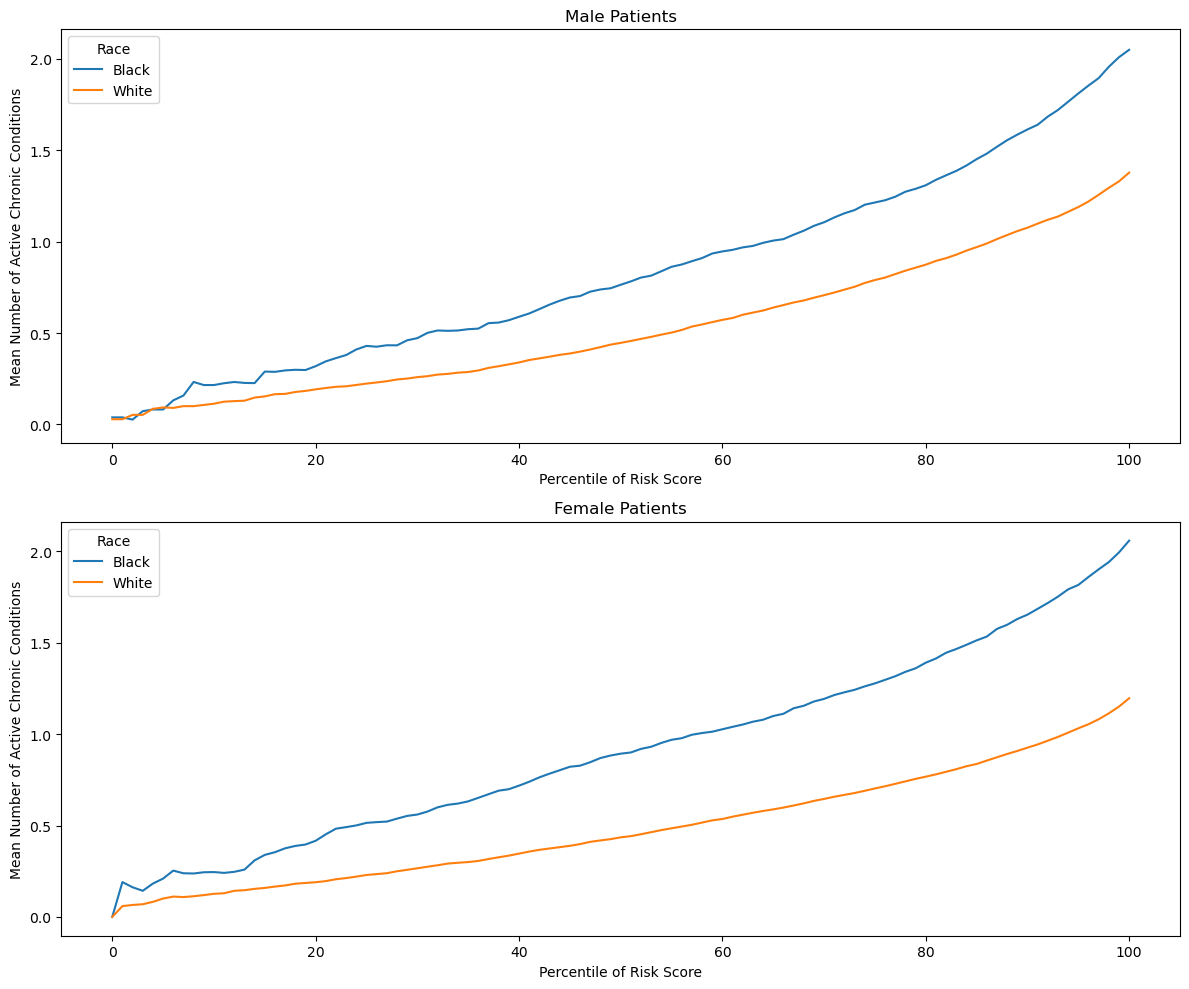

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure that 'race' values are in lowercase for consistent filtering
df['race'] = df['race'].str.lower()

# Check if race filtering works correctly
print("Race counts:", df['race'].value_counts())

df['gender'] = df['dem_female'].map({1: 'Female', 0: 'Male'})

# Check gender counts to ensure mapping is correct
print("Gender counts:", df['gender'].value_counts())

# Define genders and races for plotting
genders = ['Male', 'Female']
races = ['black', 'white']

markers = {'black': 'o', 'white': 'x'}


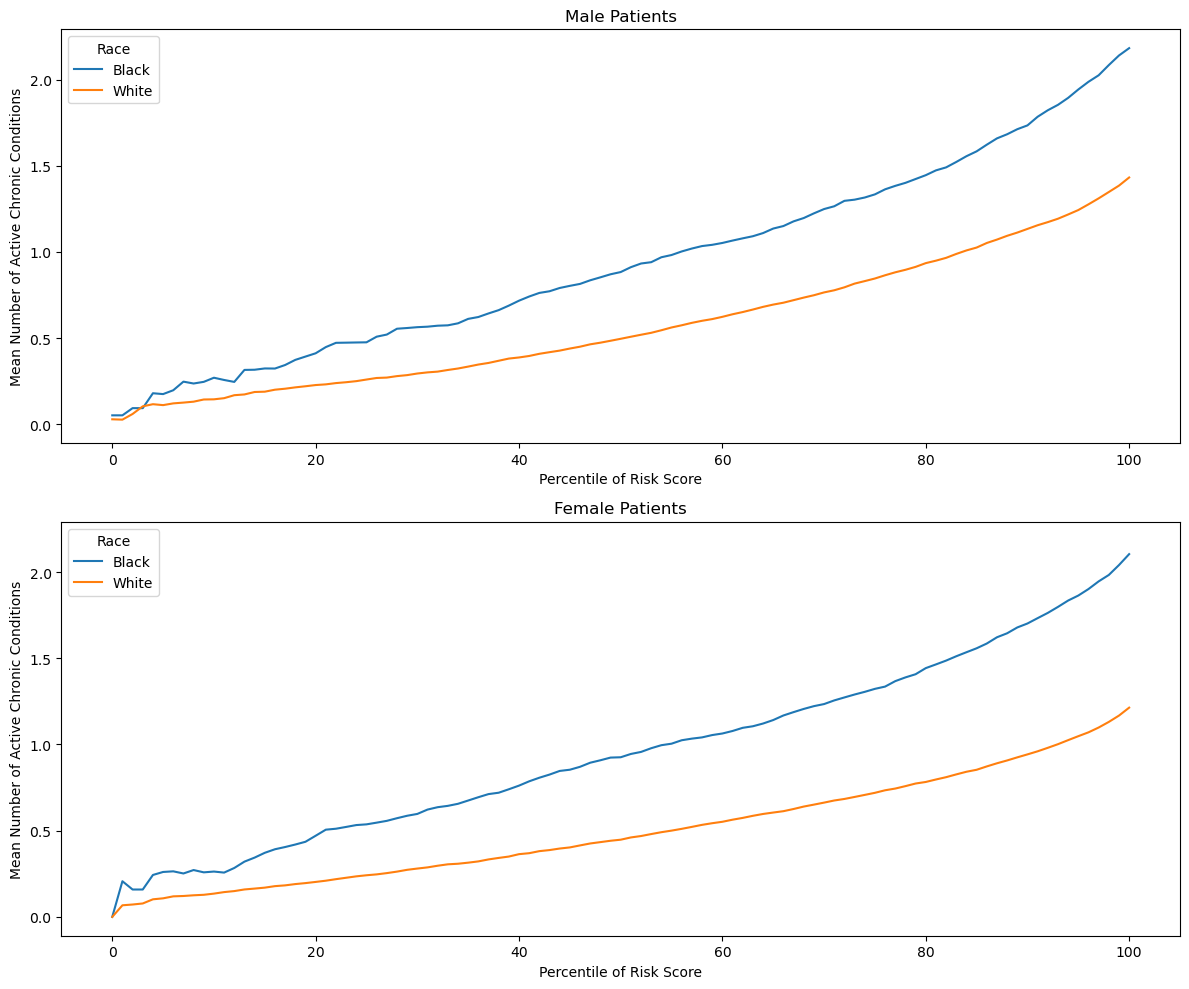

In [46]:
#| label: fig-line-risk-score
#| fig-cap: Figures of the mean number of active chronic conditions for each percentile of risk score, by gender and race

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 10), sharey=True)

for i, gender in enumerate(genders):
    for race in races:
        subset = df[(df['gender'] == gender) & (df['race'] == race)]
        
        # Check if subset is empty
        if subset.empty:
            print(f"No data for {gender} and {race}")
            continue

        # Calculate percentiles of risk score
        percentiles = np.linspace(0, 100, 101)  # 101 points from 0 to 100
        percentile_scores = np.percentile(subset['risk_score_t'], percentiles)

        # Calculate mean number of chronic conditions for each percentile
        mean_conditions = [subset[subset['risk_score_t'] <= score]['gagne_sum_t'].mean() for score in percentile_scores]
        
        # Plot
        ax = axes[i]
        ax.plot(percentiles, mean_conditions, label=f'{race.capitalize()}')
        
        ax.set_title(f'{gender} Patients')
        ax.set_xlabel('Percentile of Risk Score')
        ax.set_ylabel('Mean Number of Active Chronic Conditions')
        ax.legend(title='Race')

plt.tight_layout()
plt.show()

Algorithm scores are a key input to decisions about future enrollment in a care coordination program. So as we might expect, with less-healthy Blacks scored at similar risk scores to more-healthy Whites, we find evidence of substantial disparities in program screening. 

Say for example that Patient A is Black, Patient B is White, and that both Patient A and Patient B have exactly the same chronic illnesses. Due to the disparity seen above, Patient A is less likely to be referred to the high risk care management program due to the current risk score screening practices.


## Part C: Reproducing Fig 3. 

In this section, we will be focusing on reproducing Figure 3 from Obermeyer et al. (2019).

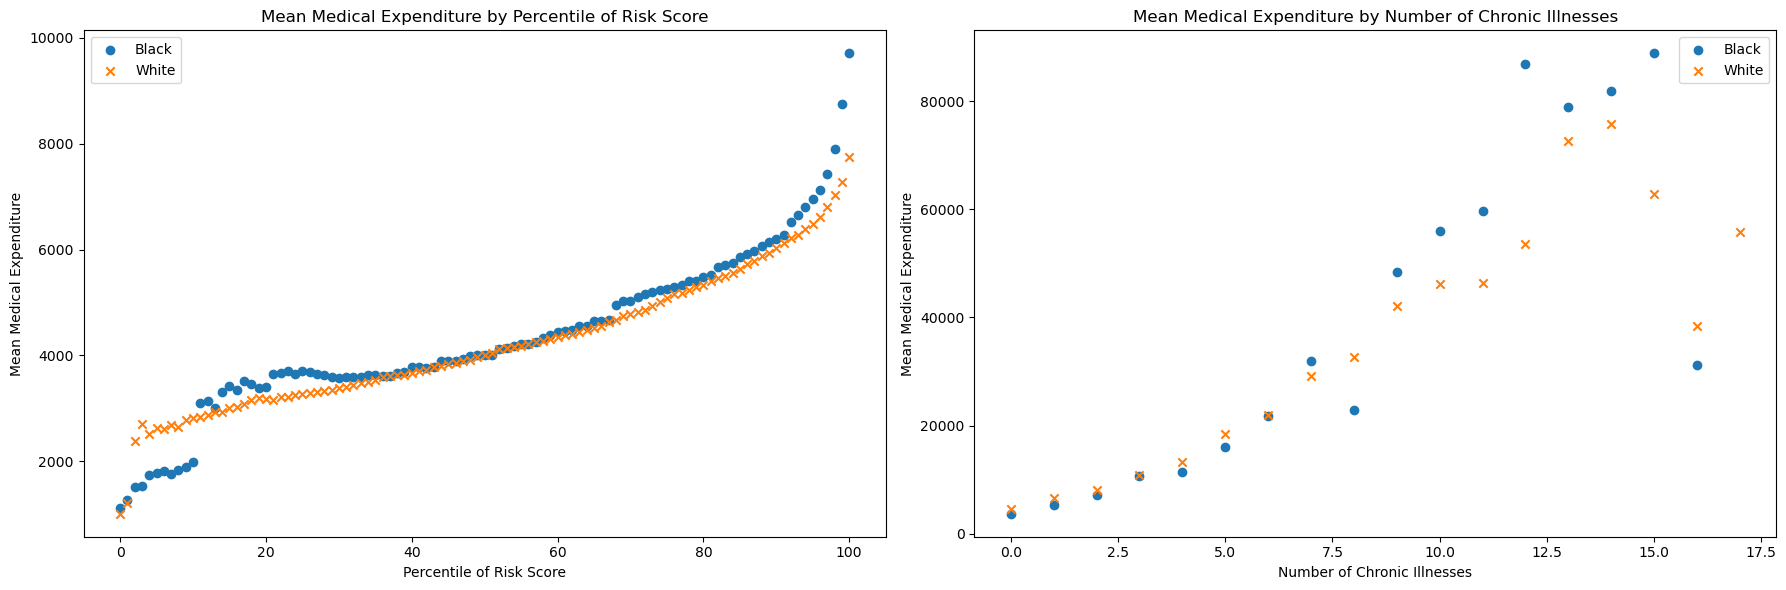

In [45]:
#| label: fig-scatter-expenditure
#| fig-cap: Scatterplots of mean medical expenditure by percentile of risk score and number of chronic illnesses

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

# Plot 1: Mean Medical Expenditure by Percentile of Risk Score
for race in ['black', 'white']:
    subset = df[df['race'] == race]
    percentiles = np.linspace(0, 100, 101)
    percentile_scores = np.percentile(subset['risk_score_t'], percentiles)
    mean_costs = [subset[subset['risk_score_t'] <= score]['cost_t'].mean() for score in percentile_scores]
    axes[0].scatter(percentiles, mean_costs, marker=markers[race], label=f'{race.capitalize()}')
axes[0].set_title('Mean Medical Expenditure by Percentile of Risk Score')
axes[0].set_xlabel('Percentile of Risk Score')
axes[0].set_ylabel('Mean Medical Expenditure')
axes[0].legend()

# Plot 2: Mean Medical Expenditure by Number of Chronic Illnesses
for race in ['black', 'white']:
    subset = df[df['race'] == race]
    unique_illnesses = sorted(subset['gagne_sum_t'].unique())
    mean_costs = [subset[subset['gagne_sum_t'] == illness]['cost_t'].mean() for illness in unique_illnesses]
    axes[1].scatter(unique_illnesses, mean_costs, marker=markers[race], label=f'{race.capitalize()}')
axes[1].set_title('Mean Medical Expenditure by Number of Chronic Illnesses')
axes[1].set_xlabel('Number of Chronic Illnesses')
axes[1].set_ylabel('Mean Medical Expenditure')
axes[1].legend()

plt.tight_layout()
plt.show()

From reproducing `Figure 3`, we find that there are small disparities in cost between races, but rather large disparities in health conditional on risk as seen in @fig-line-risk-score 

### Part D: Modeling Cost Disparity

## Data Prep

As seen in @fig-scatter-expenditure, there is a relatively stable pattern of disparity in the cost incurred by black and white patients with 5 or fewer chronic conditions, but this pattern begins to swing wildly in one direction or another as the number of active chronic conditions increases.

Due to this, we will focus on patients with 5 or fewer active chronic conditions.

We will explore the percentage of patients in the dataset with 5 or fewer active chronic conditions, create a new column in the data set called `log-transform` which will act as our target variable for our model, create a dummy column for the qualitative `race` variable, and separate the data into predictor variables `X` and target variable `y`.

In [27]:
df['five_or_less'] = df['gagne_sum_t'] <= 5
percentage_five_or_less = df['five_or_less'].mean() * 100
print(f"Percentage of patients with 5 or fewer chronic conditions: {percentage_five_or_less:.2f}%")

Percentage of patients with 5 or fewer chronic conditions: 95.54%


As seen with the percentage of patients with 5 or fewer active chronic conditions, the justification for focusing on this subset of the data is that the disparities in cost between black and white patients are relatively stable for this subset of the data and it accounts for a large portion of the data.

In [28]:
# 2. Log transform of the cost; first, remove patients with $0 medical costs
df = df[df['cost_t'] > 0]
df['log_cost'] = np.log(df['cost_t'])

# 3. Create a dummy column for race where 0 = white and 1 = black
df['race_dummy'] = (df['race'] == 'black').astype(int)

# 4. Separate the data into predictor variables X and target variable y
X = df[['race_dummy', 'gagne_sum_t']]
y = df['log_cost']


/var/folders/6z/mh947m1s1m17ylsnt3y4rkfc0000gn/T/ipykernel_99506/1712691845.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['log_cost'] = np.log(df['cost_t'])
/var/folders/6z/mh947m1s1m17ylsnt3y4rkfc0000gn/T/ipykernel_99506/1712691845.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['race_dummy'] = (df['race'] == 'black').astype(int)


## Modeling

In [35]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

# Define a function to add polynomial features to the dataset
def add_polynomial_features(X, degree):
    poly = PolynomialFeatures(degree)
    X_poly = poly.fit_transform(X)
    return X_poly, poly.get_feature_names(X.columns)

# Evaluate models with different degrees of polynomial features using cross-validation
scores = []
max_degree = 10
for degree in range(1, max_degree + 1):
    # Create a pipeline that includes polynomial feature creation and linear regression
    pipeline = Pipeline([
        ('poly', PolynomialFeatures(degree=degree)),
        ('linear', LinearRegression())
    ])
    # Use the gagne_sum_t column for polynomial features and include race_dummy directly in the features
    X_features = X.drop(columns='race_dummy')
    X_poly = np.hstack([X[['race_dummy']].values, X_features])  # Adding the race dummy variable
    score = cross_val_score(pipeline, X_poly, y, cv=5, scoring='neg_mean_squared_error')
    scores.append(np.mean(score))


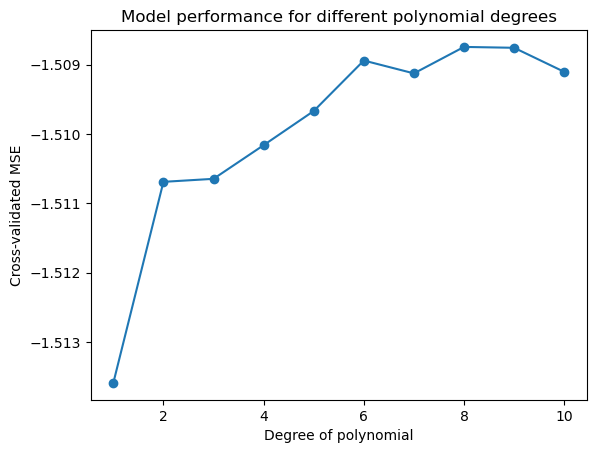

In [47]:
#| label: fig-line-degree
#| fig-cap: Line plot of cross-validated mean squared error for different polynomial degrees

plt.plot(range(1, max_degree + 1), scores, marker='o')
plt.xlabel('Degree of polynomial')
plt.ylabel('Cross-validated MSE')
plt.title('Model performance for different polynomial degrees')
plt.show()


In [ ]:

# Choose the best degree based on the plot
best_degree = np.argmax(scores) + 1
print("Best polynomial degree:", best_degree)

# Fit the final model using the best degree
pipeline = Pipeline([
    ('poly', PolynomialFeatures(degree=best_degree)),
    ('linear', LinearRegression())
])
X_features = X.drop(columns='race_dummy')
X_poly = np.hstack([X[['race_dummy']].values, X_features])
model = pipeline.fit(X_poly, y)

# Extract the coefficient for the race variable and compute e^w_b
w_b = model.named_steps['linear'].coef_[1]
cost_ratio = np.exp(w_b)
print(f"Estimated cost incurred by Black patients as a percentage of white patients: {cost_ratio * 100:.2f}%")

@fig-scatter-expenditure suggests that the relationship between the number of chronic conditions and the cost of care might be nonlinear. Due to this, we are going to fit a linear regression model with polynomial features in the number of active chronic conditions in order to to account for the nonlinearity.

THe model we use above is mathematically described as:

\begin{aligned}
  \log \mathrm{cost} \approx w_b \times (\text{patient is Black}) + \mathrm{intercept} + \sum_{i = 1}^k w_k\times (\text{gagne sum})^k\;.
\end{aligned}

In the model above, one particular feature of interest is the value of the coefficient w_b. In the context of a log-transformed linear model, w_b has the following interpretation: the number e^{w_b} is an estimate of the percentage of cost incurred by a Black patient in comparison to an equally sick white patient.

@fig-line-degree is used to explore the relationship between the number of chronic conditions and the cost of care. We find through this that a degree of 8 is the best fit for the model.

The estimate we receive suggests that Black patients incur about 96.92% of the costs incurred by white patients, given the same number of chronic conditions and assuming other factors are equal. This value is less than 100%, indicating that, per the model's findings, Black patients have slightly lower medical expenditures compared to white patients for comparable levels of illness. This supports the evidence from @fig-scatter-expenditure, which shows that the disparity in cost between black and white patients is relatively stable for patients with 5 or fewer active chronic conditions. Meaning that we do indeed see a disparity in risk scores, but only a slight disparity in cost between black and white patients.

## Discussion

The analysis conducted in this blog post reiterates the critical insights from Obermeyer et al. (2019), revealing subtle yet significant disparities in healthcare costs that suggest potential biases in the algorithms used for managing health populations. By employing polynomial regression models, we confirmed that the relationship between the number of chronic conditions and the associated healthcare costs is nonlinear and varies by race, reinforcing the need for models that adequately reflect the complexity of real-world data.

The study by Obermeyer et al. is best described using the "conditional statistical parity" criterion discussed in Chapter 3 of Barocas, Hardt, and Narayanan (2023). This criterion pertains to ensuring that a decision-making process (like an algorithm) meets a fairness condition, specifically, that it is statistically independent of sensitive attributes (like race) conditioned on a legitimate set of variables (like health needs). Obermeyer et al. (2019) revealed that the algorithm's reliance on healthcare costs as a proxy for health needs failed to account for the broader social and economic factors that influence these costs, leading to an underestimation of health needs for Black patients relative to white patients who incur similar healthcare costs.

# What I Learned

One of the biggest factors I learned throughout creating this blog post was the importance of context. Recognizing that the socio-economic context that influences how data manifests and is subsequently interpreted by algorithms can help mitigate biases and improve the fairness of algorithmic decisions. Admittedly, the analysis conducted in this blog post is limited in scope and does not account for all the complexities of healthcare disparities. However, it serves as a starting point for understanding the implications of algorithmic bias in healthcare and the need for more nuanced models that consider the multifaceted nature of health disparities.

The next question to be answered: What is fairness?
